In [31]:
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt
from dynesty import plotting as dyplot
import dynesty
from dynesty import utils as dyfunc
import scipy.stats
import scipy.special as sps
import copy
import multiprocessing as mp

# Epoch A

Loading uvfits:  ./Epoch_A/MJ1803-298.SPLIT.1
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4


/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 48449 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


estimated max_diff_sec:  165.0
Estimating noise rescaling factor from 30 triangles...

anomalous amp flagged 122/1523 visibilities
anomalous snr flagged 43/1401 visibilities
Flagged 0/1358 visibilities


/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 1358 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1358 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


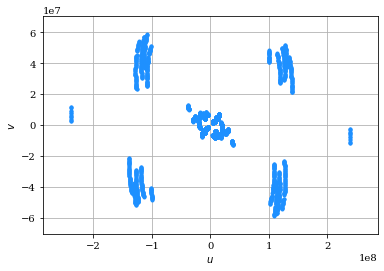

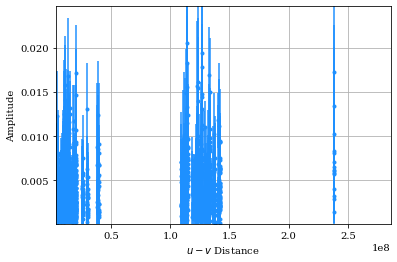

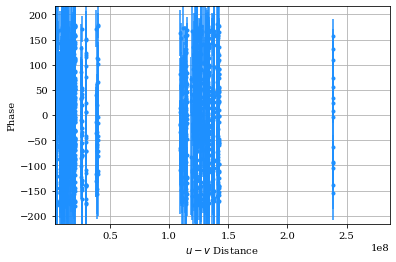

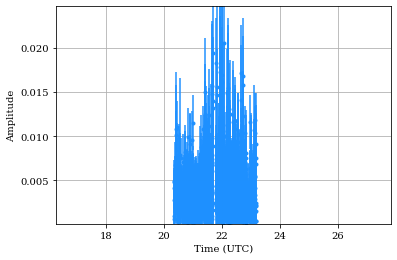

/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


In [32]:
pathname = './Epoch_A/'
filename = 'MJ1803-298.SPLIT.1' 

outtag = 'final'

obs = eh.obsdata.load_uvfits(pathname + filename)

t0 = obs.tstart
obs = obs.avg_coherent(60) 

noise_scale_factor = obs.estimate_noise_rescale_factor()

obs = obs.rescale_noise(noise_scale_factor)

obs = obs.flag_anomalous('amp',max_diff_seconds=300.0)
obs = obs.flag_anomalous('snr',max_diff_seconds=300.0)

obs = obs.flag_elev(elev_min = 10)


# Show some diagnostic plots
obs.plotall('u','v',conj=True)
obs.plotall('uvdist','amp')
obs.plotall('uvdist','phase')
obs.plotall('time_utc','amp')

# extract array of observation data
obsData = obs.unpack(['time_utc','u','v','amp','sigma','phase','sigma_phase','vis'],debias=True,conj=False)

# grab array of full list of sigmas for normalisation
sigma_full = obsData['sigma'] # list of all sigmas
vis_full = obsData['vis']
u_full = obsData['u']
v_full = obsData['v']

vis = []
u = []
v = []
sigma = []
times = []
amp = []
phase = []
sigma_phase = []

amp_full = obsData['amp']
u_full = obsData['u']
v_full = obsData['v']

# get data in scan ordered format
data = obs.tlist()

numScans = 0
max_sigma = 0
for ii in range(len(data)):

    # grab data from scan ordered tlist() array
    vis.append(data[ii]['vis'])
    times.append(data[ii]['time'])
    u.append(data[ii]['u'])
    v.append(data[ii]['v'])
    sigma.append(data[ii]['sigma'])

    numScans = numScans + 1

    max = np.max(data[ii]['sigma'])
    if max > max_sigma:
        max_sigma = max

obslength = obs.tstop - obs.tstart

In [33]:
# define prior transform and loglikelihood
def prior_transform(u):

    # u[0]:Flux (Jy)
    # u[1]:x0 (rad)
    # u[2]:y0 (rad)
    # u[3]:FWHM_maj (rad)
    # u[4]:rdot (mas/hr)
    # u[5]:theta (rad)
    # u[6]:fdot (Jy/hr)
    
    x = np.array(u)

    x[0] = scipy.stats.uniform.ppf(u[0],loc = 0, scale = 0.01)

    x[1] = scipy.stats.norm.ppf(u[1],loc = 0 * 1000 * eh.RADPERUAS, scale = 5 * 1000 * eh.RADPERUAS)

    x[2] = scipy.stats.norm.ppf(u[2],loc = 0 * 1000 * eh.RADPERUAS, scale = 5 * 1000 * eh.RADPERUAS)

    x[3] = scipy.stats.uniform.ppf(u[3], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)

    x[4] = scipy.stats.uniform.ppf(u[4], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)

    x[5] = scipy.stats.uniform.ppf(u[5], loc = 0, scale = 2*np.pi)

    df_max = x[0] / obslength

    x[6] = scipy.stats.uniform.ppf(u[6], loc = -df_max, scale = df_max+0.01)

    return x


def logprior(u):
    
    f = scipy.stats.uniform.logpdf(u[0],loc = 0, scale = 0.01)

    x0 = scipy.stats.norm.logpdf(u[1],loc = 0 * 1000 * eh.RADPERUAS, scale = 5 * 1000 * eh.RADPERUAS)

    y0 = scipy.stats.norm.logpdf(u[2],loc = 0 * 1000 * eh.RADPERUAS, scale = 5 * 1000 * eh.RADPERUAS)

    fwhm = scipy.stats.uniform.logpdf(u[3], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)

    rdot = scipy.stats.uniform.logpdf(u[4], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)

    theta = scipy.stats.uniform.logpdf(u[5], loc = 0, scale = 2*np.pi)
    
    df_max = u[0] / obslength
    
    fdot = scipy.stats.uniform.logpdf(u[6], loc = -df_max, scale = df_max+0.01)
    
    return f + x0 + y0 + fwhm + rdot + theta + fdot


def gaussian_circ_moving_radial(x,scan,u_scan,v_scan):
    # x[0]:Flux (Jy)
    # x[1]:x0 (rad)
    # x[2]:y0 (rad)
    # x[3]:FWHM (rad)
    # x[4]:rdot (rad/hr)
    # x[5]:theta (rad)
    # x[6]:fdot (Jy/hr)

    xpos = (x[1] + x[4] * (times[scan][0]-t0) * np.sin(x[5])) * np.cos(-29.8303925/180*np.pi)
    ypos =  x[2] + x[4] * (times[scan][0]-t0) * np.cos(x[5]) 
    flux =  x[0] + x[6] * (times[scan][0]-t0)
    

    return flux * np.exp(-np.pi**2/(4.*np.log(2.)) * (u_scan**2 + v_scan**2) * x[3]**2) \
                * np.exp(1j * 2.0 * np.pi * (u_scan * xpos + v_scan * ypos))

def loglike(x):

    loglike = 0

    for scan in range(len(data)):
        
        model = gaussian_circ_moving_radial(x,scan,u[scan],v[scan])
        loglike = loglike - 0.5*np.sum((np.abs(model-vis[scan])/sigma[scan])**2)

    return loglike - np.sum(np.log((2.0*np.pi)**0.5 * sigma_full))

def logpost(x):
    return loglike(x) + logprior(x)


In [34]:
processes = 16

pool = mp.Pool(processes=processes)

sampler = dynesty.DynamicNestedSampler(loglike, prior_transform,ndim=7,pool=pool,queue_size=processes)

sampler.run_nested()

results = sampler.results
results.summary()

if pool is not None:
    pool.close()
pool = None

18793it [16:42, 18.74it/s, batch: 5 | bound: 211 | nc: 38 | ncall: 1042553 | eff(%):  1.803 | loglstar: 4572.122 < 4578.648 < 4577.608 | logz: 4560.467 +/-  0.134 | stop:  0.945]        

Summary
niter: 18793
ncall: 1042553
eff(%):  1.803
logz: 4560.443 +/-  0.114


In [35]:
if pool is not None:
    pool.close()
pool = None

results = sampler.results
results.summary()

# Extract useful sampling diagnostics.
samples = results.samples                             # samples
weights = np.exp(results.logwt - results.logz[-1])        # normalized weights
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Compute the log-posterior
print('Calculating the posterior values for the samples...')

def calclogpost(j):
    return loglike(samples[j]) + logprior(samples[j])

pool = mp.Pool(processes=processes)

logposterior = pool.map(calclogpost, range(len(samples)))

if pool is not None:
    pool.close()
pool = None

# Select the MAP
j_MAP = np.argmax(logposterior)
MAP  = samples[j_MAP]

# Resample from the posterior
samples = dyfunc.resample_equal(samples, weights) 

std = cov.diagonal()**0.5

# scale to sensible units

results_natural = copy.deepcopy(results)

samples_natural = samples / np.array([1e-3,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,np.pi/180,1e-3])
results_natural.samples[:,:] /= np.array([1e-3,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,np.pi/180,1e-3])
MAP_natural = MAP / np.array([1e-3,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,np.pi/180,1e-3])


Summary
niter: 18793
ncall: 1042553
eff(%):  1.803
logz: 4560.443 +/-  0.114
Calculating the posterior values for the samples...


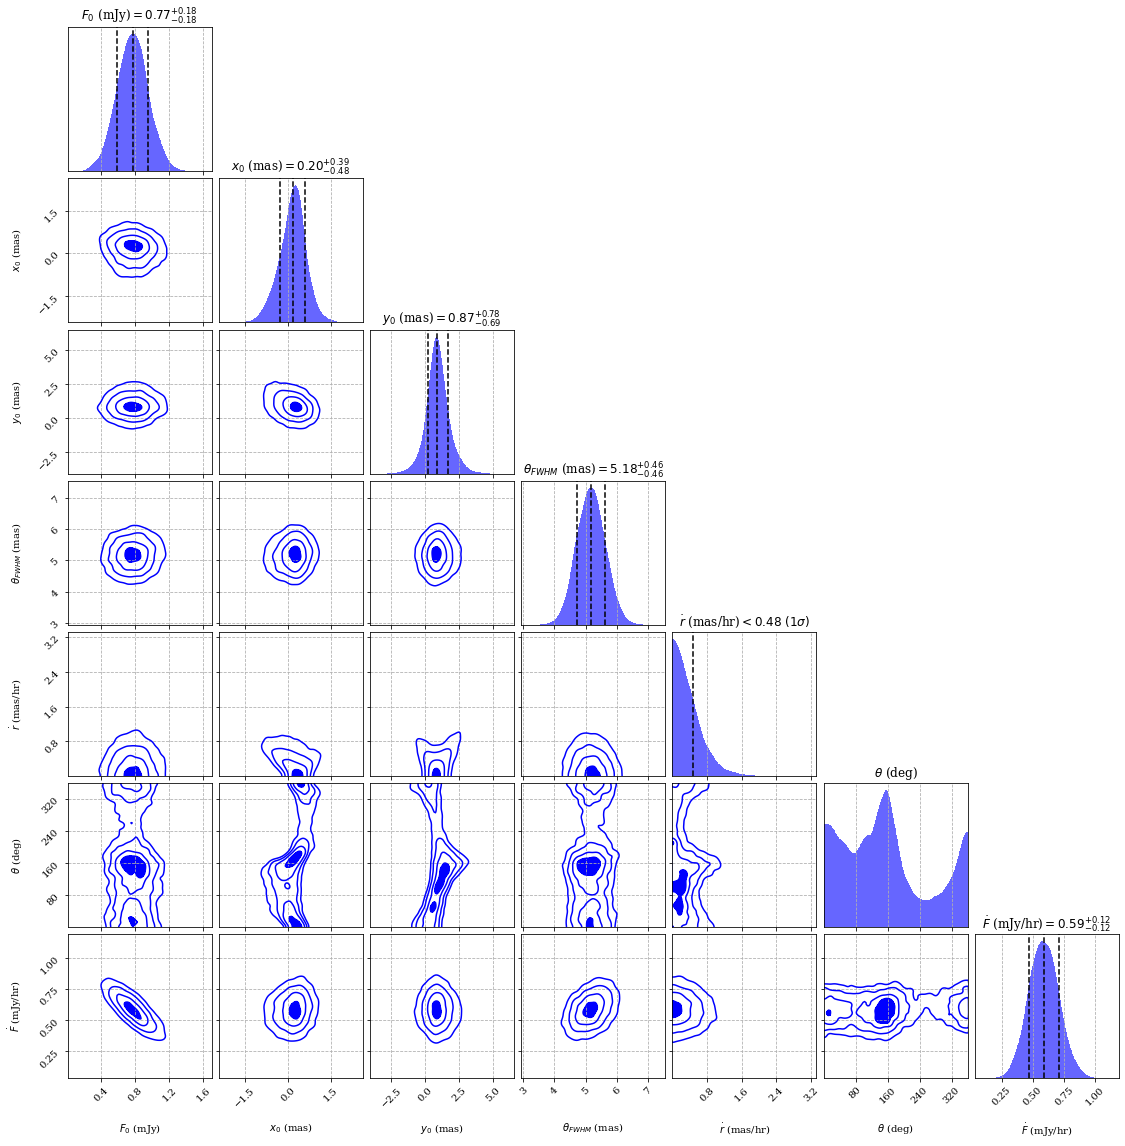

In [36]:
label_names = [r'$F_0$ (mJy)',r'$x_0$ (mas)', r'$y_0$ (mas)', r'$\theta_{FWHM}$ (mas)',r'$\dot{r}$ (mas/hr)',r'$\theta$ (deg)',r'$\dot{F}$ (mJy/hr)']

# plot results 
fig, ax = dyplot.cornerplot(results_natural, labels = label_names,color='blue', show_titles=False, title_quantiles=None,quantiles=None)

for ii in (0,1,2,3,6):
    median = np.quantile(samples_natural[:,ii],0.5)
    min = np.quantile(samples_natural[:,ii],0.5)-np.quantile(samples_natural[:,ii],0.16)
    max = np.quantile(samples_natural[:,ii],0.84)-np.quantile(samples_natural[:,ii],0.5)
    ax[ii,ii].set_title(label_names[ii]+f'$={median:.2f}_{{-{min:.2f}}}^{{+{max:.2f}}}$')
    ax[ii,ii].axvline(median,ls='--',color='black')
    ax[ii,ii].axvline(median+max,ls='--',color='black')
    ax[ii,ii].axvline(median-min,ls='--',color='black')
    
# rdot
max = np.quantile(samples_natural[:,4],0.68)
ax[4,4].set_title(label_names[4]+f'$<{max:.2f}$ $(1\sigma)$')
ax[4,4].axvline(max,ls='--',color='black')

# theta
ax[5,5].set_title(label_names[5])

for ii in range(len(label_names)):
    for jj in range(len(label_names)):
        ax[ii,jj].grid(linestyle='--')
        
fig.savefig(pathname + 'triangle' + outtag + '.pdf',bbox_inches='tight')   

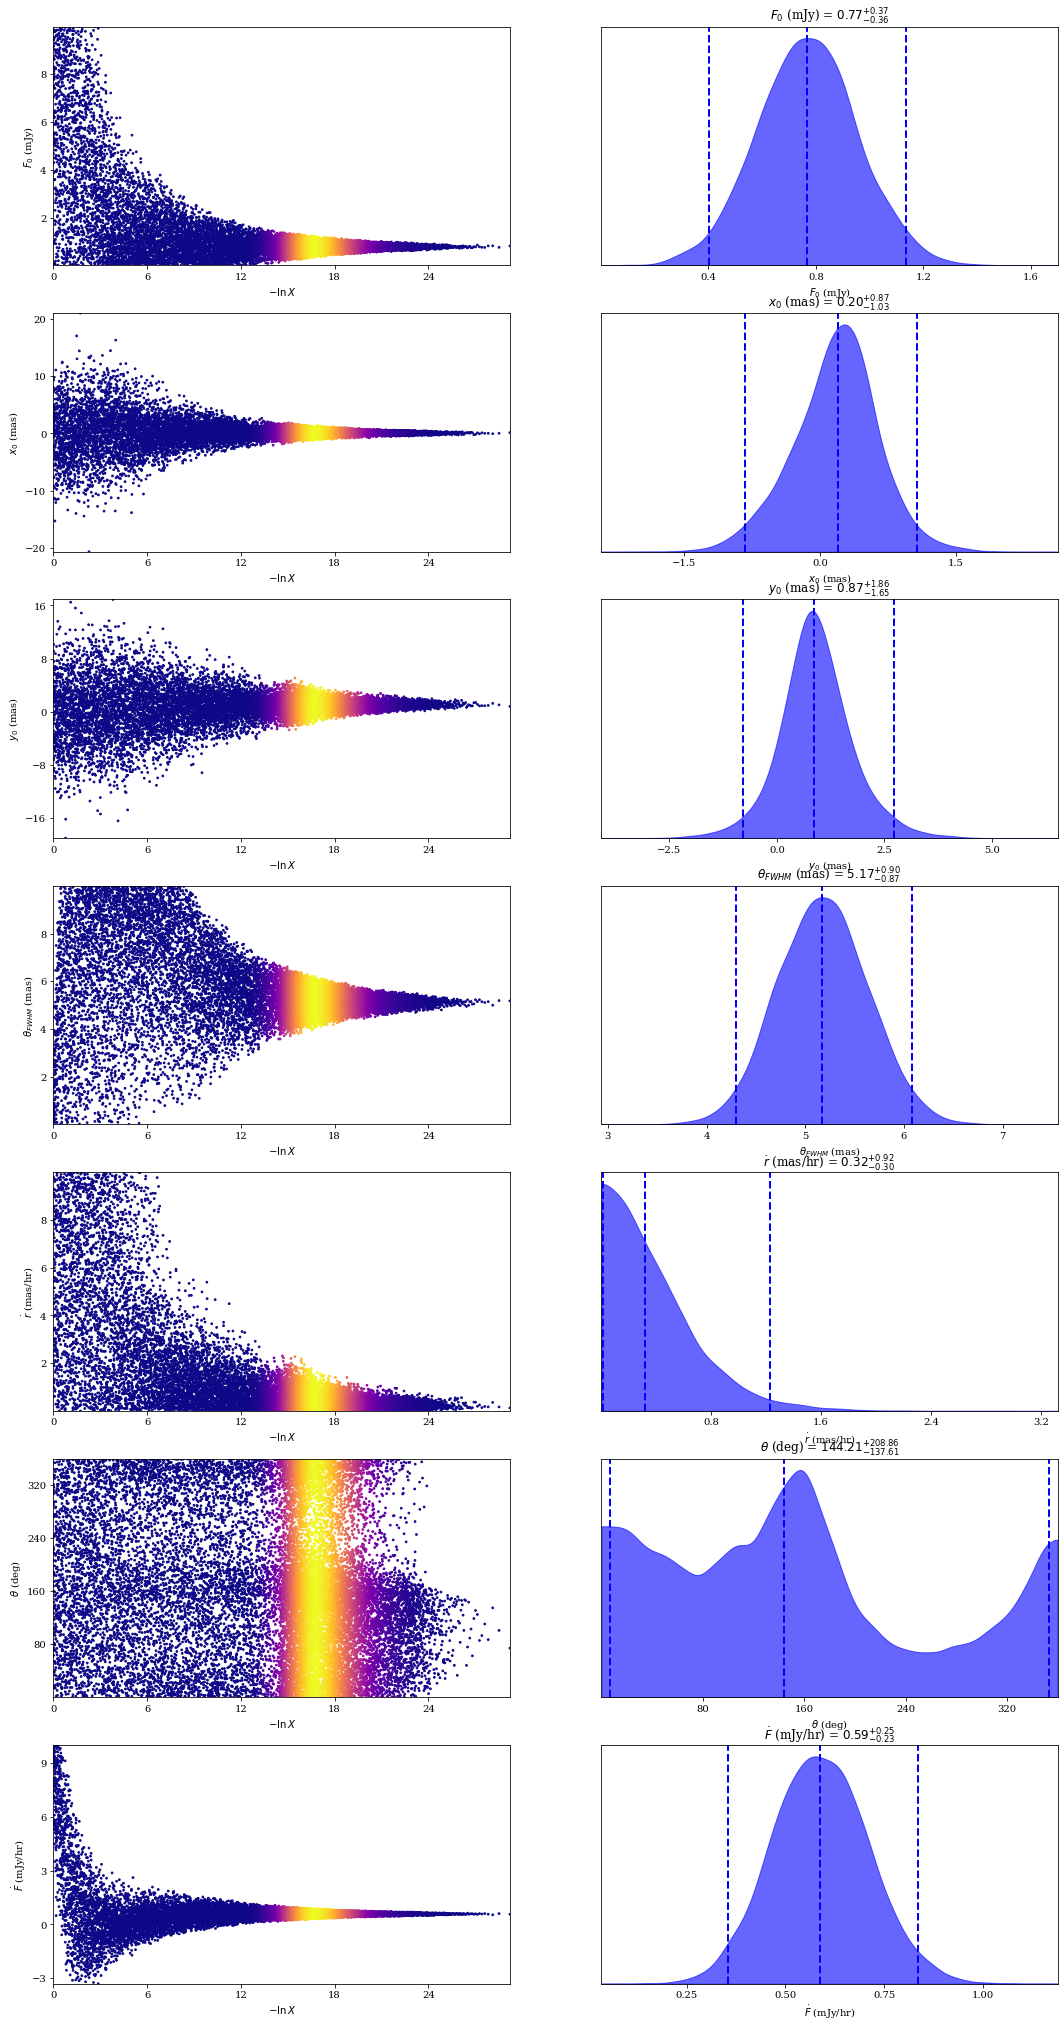

In [37]:
fig, axes=plt.subplots(nrows=7,ncols=2,figsize=(18,36))
dyplot.traceplot(results_natural,fig=(fig,axes),
                             truth_color='black', show_titles=True,
                             trace_cmap='plasma', connect=False,labels = label_names,
                             connect_highlight=range(5))

fig.savefig(pathname + 'trace' + outtag + '.pdf',bbox_inches='tight')

In [38]:
np.save(pathname+outtag+'_results.npy',results)
np.save(pathname+outtag+'_results_natural.npy',results_natural)

# Epoch B

Loading uvfits:  ./Epoch_B/MJ1803-298.SPLIT.1
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4


/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 41824 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


estimated max_diff_sec:  180.0
Estimating noise rescaling factor from 45 triangles...

anomalous amp flagged 67/1148 visibilities
anomalous snr flagged 31/1081 visibilities
Flagged 0/1050 visibilities


/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 1050 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1050 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


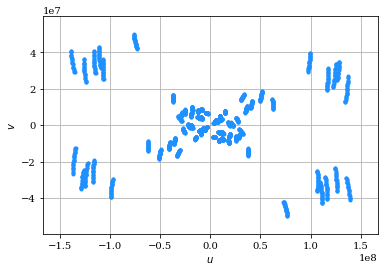

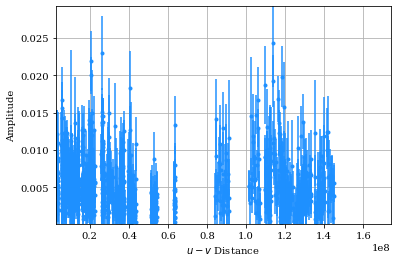

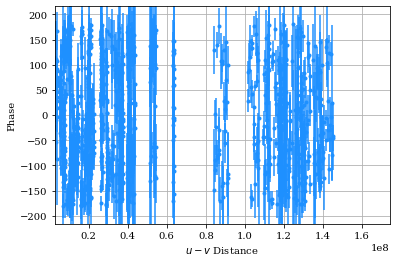

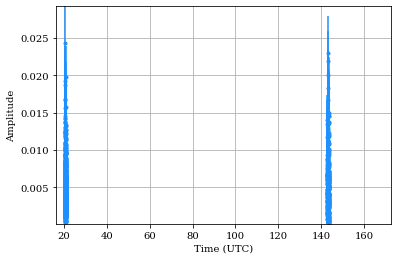

/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


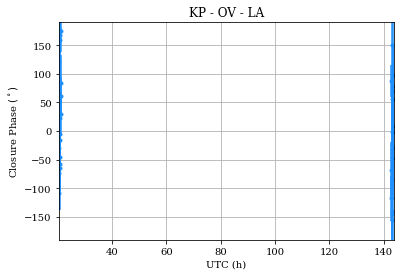

20.302361011505127


/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


In [39]:
pathname = './Epoch_B/'
filename = 'MJ1803-298.SPLIT.1'

outtag = 'final'

obs = eh.obsdata.load_uvfits(pathname + filename)

t0 = obs.tstart
obs = obs.avg_coherent(60) 

noise_scale_factor = obs.estimate_noise_rescale_factor()
obs = obs.rescale_noise(noise_scale_factor)

obs = obs.flag_anomalous('amp',max_diff_seconds=300.0)
obs = obs.flag_anomalous('snr',max_diff_seconds=300.0)

# Flag low elevations
obs = obs.flag_elev(elev_min = 10)

# Show some example plots
obs.plotall('u','v',conj=True)
obs.plotall('uvdist','amp')
obs.plotall('uvdist','phase')
obs.plotall('time_utc','amp')
obs.plot_cphase('KP','OV','LA')

# extract array of observation data
obsData = obs.unpack(['time_utc','u','v','amp','sigma','phase','sigma_phase','vis'],debias=True,conj=False)

# grab array of full list of sigmas for normalisation
sigma_full = obsData['sigma'] # list of all sigmas
vis_full = obsData['vis']
u_full = obsData['u']
v_full = obsData['v']

vis = []
u = []
v = []
sigma = []
times = []
amp = []
phase = []
sigma_phase = []

amp_full = obsData['amp']
u_full = obsData['u']
v_full = obsData['v']

# get data in scan ordered format
data = obs.tlist()

numScans = 0
max_sigma = 0
for ii in range(len(data)):

    # grab data from scan ordered tlist() array
    vis.append(data[ii]['vis'])
    if data[ii]['time'][0] > 60: # for dbcon adding 5 days to B2 in scan table
        times.append(data[ii]['time']-120)
    else:
        times.append(data[ii]['time'])
    u.append(data[ii]['u'])
    v.append(data[ii]['v'])
    sigma.append(data[ii]['sigma'])

    numScans = numScans + 1

    max = np.max(data[ii]['sigma'])
    if max > max_sigma:
        max_sigma = max

obslength = obs.tstop - obs.tstart - 120
print(t0)

In [40]:
# define prior transform and loglikelihood
def prior_transform(u):

    # u[0]:Flux (Jy)
    # u[1]:x0 (rad)
    # u[2]:y0 (rad)
    # u[3]:FWHM_maj (rad)
    # u[4]:rdot (mas/hr)
    # u[5]:theta (rad)
    # u[6]:fdot (Jy/hr)

    x = np.array(u)

    x[0] = scipy.stats.uniform.ppf(u[0],loc = 0, scale = 0.01)

    x[1] = scipy.stats.norm.ppf(u[1],loc = 10 * 1000 * eh.RADPERUAS, scale = 5 * 1000 * eh.RADPERUAS)

    x[2] = scipy.stats.norm.ppf(u[2],loc = -5 * 1000 * eh.RADPERUAS, scale = 5 * 1000 * eh.RADPERUAS)
    
    x[3] = scipy.stats.uniform.ppf(u[3], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)

    x[4] = scipy.stats.uniform.ppf(u[4], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)

    x[5] = scipy.stats.norm.ppf(u[5], loc = 135 / 180 * np.pi, scale = 15 /180*np.pi)

    df_max = x[0] / obslength

    x[6] = scipy.stats.uniform.ppf(u[6], loc = -df_max, scale = df_max+0.01)

    return x


def logprior(u):
    
    f = scipy.stats.uniform.logpdf(u[0],loc = 0, scale = 0.01)

    x0 = scipy.stats.norm.logpdf(u[1],loc = 10 * 1000 * eh.RADPERUAS, scale = 5 * 1000 * eh.RADPERUAS)

    y0 = scipy.stats.norm.logpdf(u[2],loc = -5 * 1000 * eh.RADPERUAS, scale = 5 * 1000 * eh.RADPERUAS)

    fwhm = scipy.stats.uniform.logpdf(u[3], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)

    rdot = scipy.stats.uniform.logpdf(u[4], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)

    theta = scipy.stats.norm.logpdf(u[5], loc = 135 /180*np.pi, scale = 25 /180*np.pi)
    
    df_max = u[0] / obslength
    fdot = scipy.stats.uniform.logpdf(u[6], loc = -df_max, scale = df_max+0.01)
    
    return f + x0 + y0 + fwhm + rdot + theta + fdot


def gaussian_circ_moving_radial(x,scan,u_scan,v_scan):
    # x[0]:Flux (Jy)
    # x[1]:x0 (rad)
    # x[2]:y0 (rad)
    # x[3]:FWHM (rad)
    # x[4]:rdot (rad/hr)
    # x[5]:theta (rad)
    # x[6]:fdot (Jy/hr)

    # theta is angle from x-axis
    xpos = (x[1] + x[4] * (times[scan][0]-t0) * np.sin(x[5])) * np.cos(obs.dec/180*np.pi)
    ypos =  x[2] + x[4] * (times[scan][0]-t0) * np.cos(x[5]) 
    flux =  x[0] + x[6] * (times[scan][0]-t0)
    

    return flux * np.exp(-np.pi**2/(4.*np.log(2.)) * (u_scan**2 + v_scan**2) * x[3]**2) \
                * np.exp(1j * 2.0 * np.pi * (u_scan * xpos + v_scan * ypos))

def loglike(x):

    loglike = 0

    for scan in range(len(data)):
        
        model = gaussian_circ_moving_radial(x,scan,u[scan],v[scan])
        loglike = loglike - 0.5*np.sum((np.abs(model-vis[scan])/sigma[scan])**2)

    return loglike - np.sum(np.log((2.0*np.pi)**0.5 * sigma_full))

def logpost(x):
    return loglike(x) + logprior(x)

In [41]:
processes = 16

pool = mp.Pool(processes=processes)

sampler = dynesty.DynamicNestedSampler(loglike, prior_transform,ndim=7,pool=pool,queue_size=processes)

sampler.run_nested()

results = sampler.results
results.summary()

if pool is not None:
    pool.close()
pool = None

21629it [09:23, 38.36it/s, batch: 4 | bound: 122 | nc: 76 | ncall: 551723 | eff(%):  3.920 | loglstar: 2993.290 < 3000.303 < 2998.718 | logz: 2975.565 +/-  0.162 | stop:  0.922]        

Summary
niter: 21629
ncall: 551723
eff(%):  3.920
logz: 2975.577 +/-  0.141


In [42]:
if pool is not None:
    pool.close()
pool = None

results = sampler.results
results.summary()

# Extract useful sampling diagnostics.
samples = results.samples                             # samples
weights = np.exp(results.logwt - results.logz[-1])        # normalized weights
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Compute the log-posterior
print('Calculating the posterior values for the samples...')

def calclogpost(j):
    return loglike(samples[j]) + logprior(samples[j])

pool = mp.Pool(processes=processes)

logposterior = pool.map(calclogpost, range(len(samples)))

if pool is not None:
    pool.close()
pool = None

# Select the MAP
j_MAP = np.argmax(logposterior)
MAP  = samples[j_MAP]

# Resample from the posterior
samples = dyfunc.resample_equal(samples, weights) 

std = cov.diagonal()**0.5

# scale to sensible units

results_natural = copy.deepcopy(results)

samples_natural = samples / np.array([1e-3,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,np.pi/180,1e-3])
results_natural.samples[:,:] /= np.array([1e-3,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,np.pi/180,1e-3])
MAP_natural = MAP / np.array([1e-3,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,np.pi/180,1e-3])


Summary
niter: 21629
ncall: 551723
eff(%):  3.920
logz: 2975.577 +/-  0.141
Calculating the posterior values for the samples...


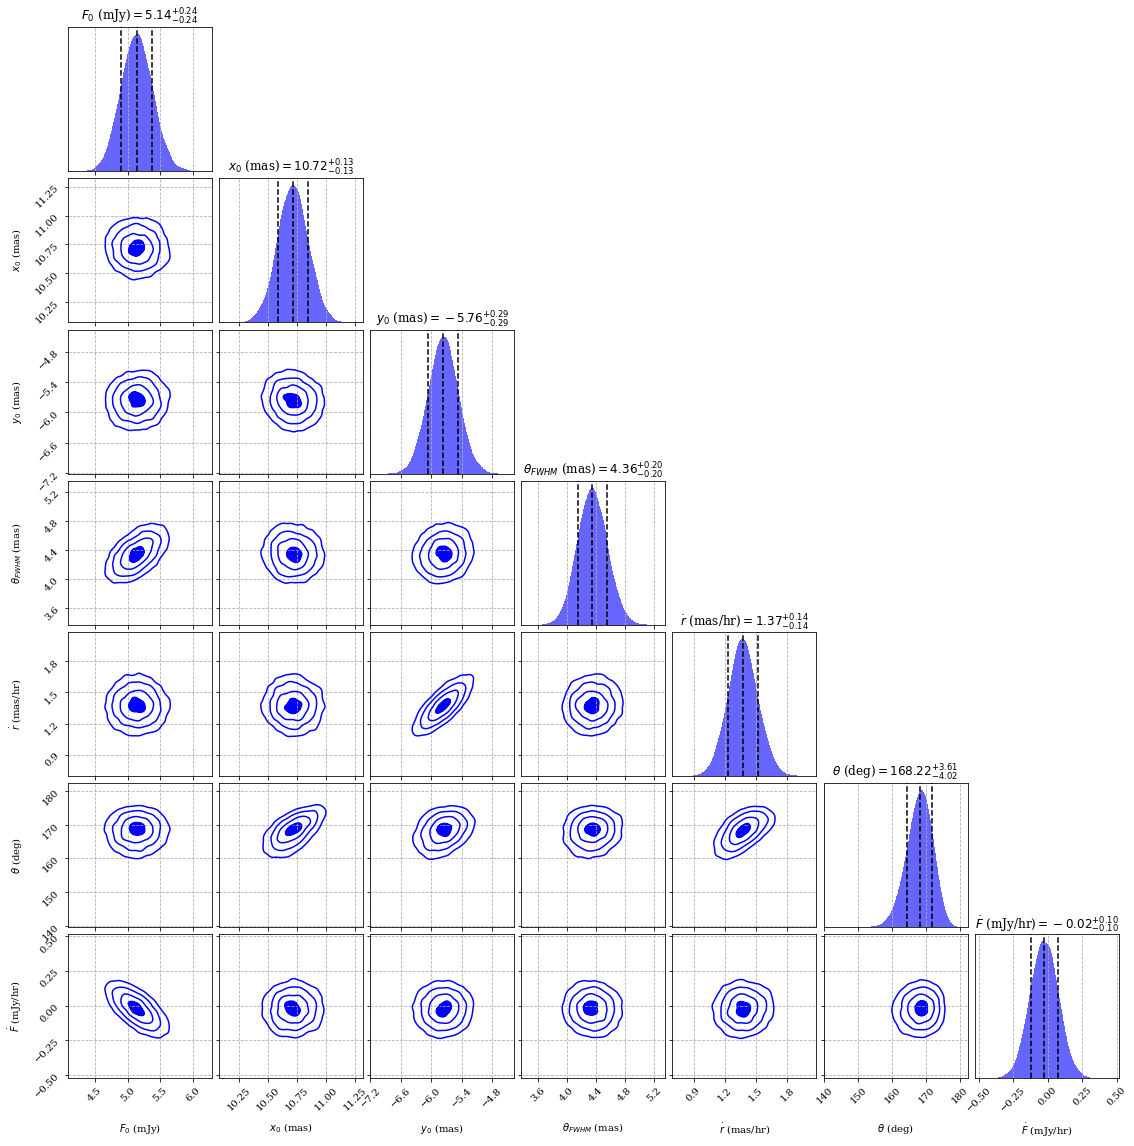

In [43]:

label_names = [r'$F_0$ (mJy)',r'$x_0$ (mas)', r'$y_0$ (mas)', r'$\theta_{FWHM}$ (mas)',r'$\dot{r}$ (mas/hr)',r'$\theta$ (deg)',r'$\dot{F}$ (mJy/hr)']

# plot results 
fig, ax = dyplot.cornerplot(results_natural, labels = label_names,color='blue', show_titles=False, title_quantiles=None,quantiles=None)

for ii in range(len(label_names)):
    for jj in range(len(label_names)):
        ax[ii,jj].grid(linestyle='--')
        
for ii in (0, 1, 2, 3, 4, 5, 6):
    median = np.quantile(samples_natural[:,ii],0.5)
    min = np.quantile(samples_natural[:,ii],0.5)-np.quantile(samples_natural[:,ii],0.16)
    max = np.quantile(samples_natural[:,ii],0.84)-np.quantile(samples_natural[:,ii],0.5)
    ax[ii,ii].set_title(label_names[ii]+f'$={median:.2f}_{{-{min:.2f}}}^{{+{max:.2f}}}$')
    ax[ii,ii].axvline(median,ls='--',color='black')
    ax[ii,ii].axvline(median+max,ls='--',color='black')
    ax[ii,ii].axvline(median-min,ls='--',color='black')


fig.savefig(pathname + 'triangle' + outtag + '.pdf',bbox_inches='tight')

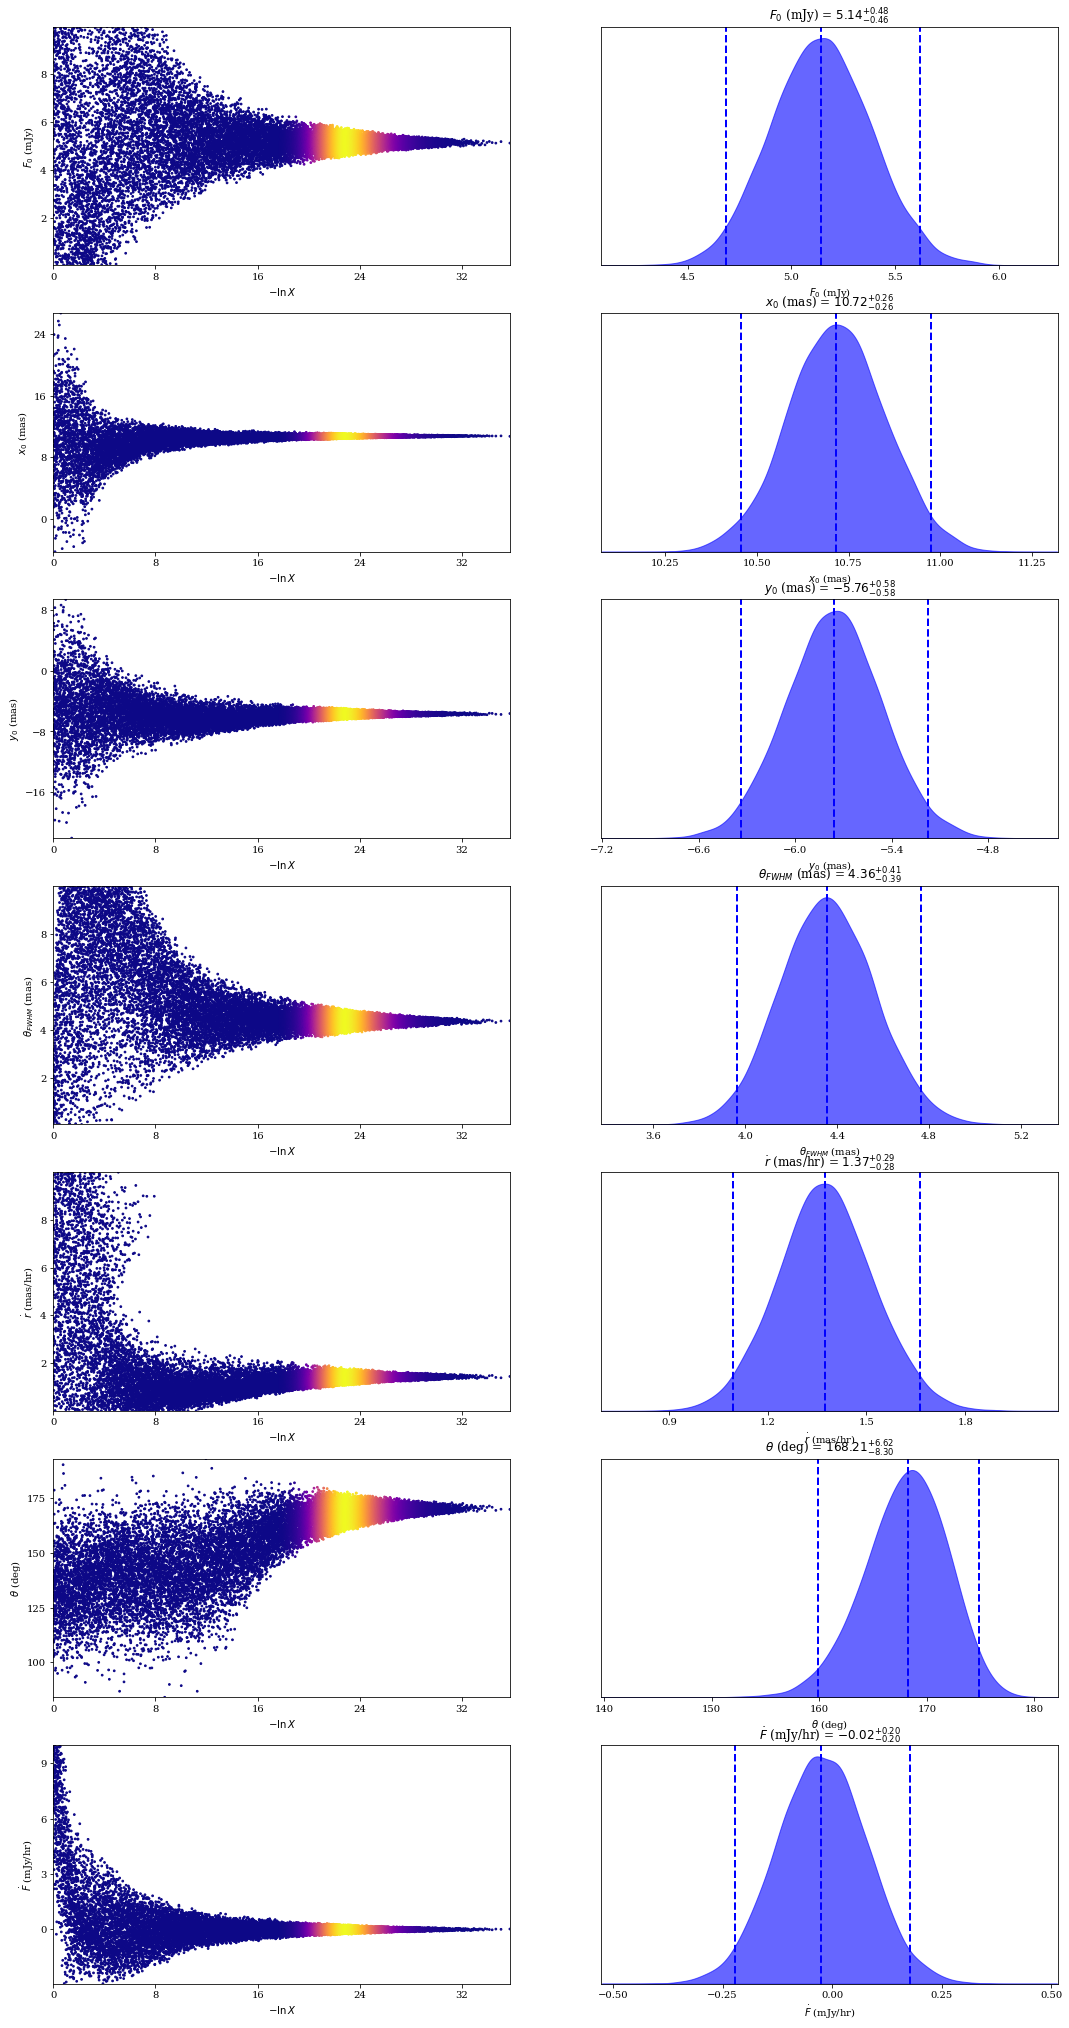

In [44]:
fig, axes=plt.subplots(nrows=7,ncols=2,figsize=(18,36))
dyplot.traceplot(results_natural,fig=(fig,axes),
                             truth_color='black', show_titles=True,
                             trace_cmap='plasma', connect=False,labels = label_names,
                             connect_highlight=range(5))

fig.savefig(pathname + 'trace' + outtag + '.pdf',bbox_inches='tight')

In [45]:
np.save(pathname+outtag+'_results.npy',results)
np.save(pathname+outtag+'_results_natural.npy',results_natural)

# Epoch C

Loading uvfits:  ./Epoch_C/MJ1803-298.SPLIT.1
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4


/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 115741 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


estimated max_diff_sec:  190.0


/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Estimating noise rescaling factor from 120 triangles...

anomalous amp flagged 243/3279 visibilities
anomalous snr flagged 123/3036 visibilities
Flagged 264/2913 visibilities


/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 2913 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 2913 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


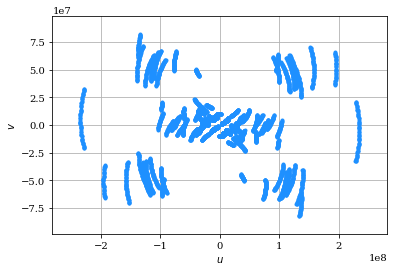

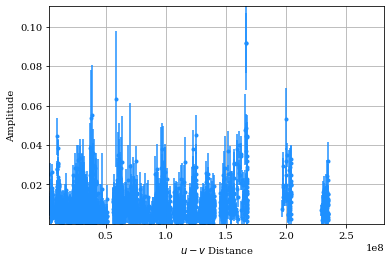

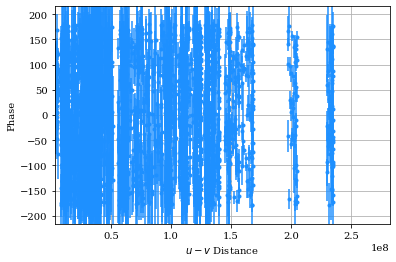

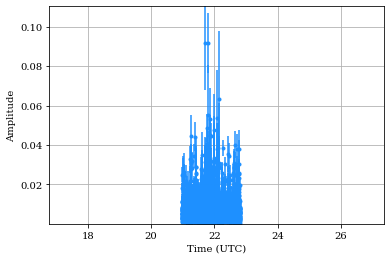

/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


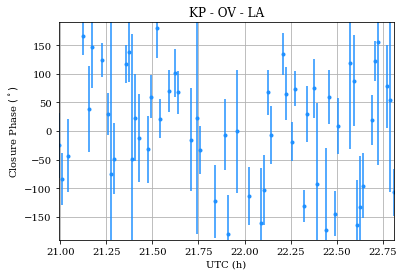

20.984583377838135
1.8166666701436043


/home/callan/anaconda3/envs/py3/lib/python3.10/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


In [46]:
# First lets try and extract some lightcurves

pathname = './Epoch_C/'
filename = 'MJ1803-298.SPLIT.1' 

outtag = 'final'

obs = eh.obsdata.load_uvfits(pathname + filename)

t0 = obs.tstart
obs = obs.avg_coherent(60) 

noise_scale_factor = obs.estimate_noise_rescale_factor()

obs = obs.rescale_noise(noise_scale_factor)

obs = obs.flag_anomalous('amp',max_diff_seconds=300.0)
obs = obs.flag_anomalous('snr',max_diff_seconds=300.0)

# Flag low elevations
obs = obs.flag_elev(elev_min = 10)

# Show some example plots
obs.plotall('u','v',conj=True)
obs.plotall('uvdist','amp')
obs.plotall('uvdist','phase')
obs.plotall('time_utc','amp')
obs.plot_cphase('KP','OV','LA')

# extract array of observation data
obsData = obs.unpack(['time_utc','u','v','amp','sigma','phase','sigma_phase','vis'],debias=True,conj=False)

# grab array of full list of sigmas for normalisation
sigma_full = obsData['sigma'] # list of all sigmas
vis_full = obsData['vis']
u_full = obsData['u']
v_full = obsData['v']

vis = []
u = []
v = []
sigma = []
times = []
amp = []
phase = []
sigma_phase = []

amp_full = obsData['amp']
u_full = obsData['u']
v_full = obsData['v']

# get data in scan ordered format
data = obs.tlist()

numScans = 0
max_sigma = 0
for ii in range(len(data)):

    # grab data from scan ordered tlist() array
    vis.append(data[ii]['vis'])
    times.append(data[ii]['time'])
    u.append(data[ii]['u'])
    v.append(data[ii]['v'])
    sigma.append(data[ii]['sigma'])

    numScans = numScans + 1

    max = np.max(data[ii]['sigma'])
    if max > max_sigma:
        max_sigma = max

print(t0)

obslength = obs.tstop - obs.tstart

print(obslength)

In [47]:
# define prior transform and loglikelihood
def prior_transform(u):

    # u[0]:Flux (Jy)
    # u[1]:x0 (rad)
    # u[2]:y0 (rad)
    # u[3]:FWHM_maj (rad)
    # u[4]:fdot (Jy/hr)

    # copy array
    x = np.array(u)

    x[0] = scipy.stats.uniform.ppf(u[0],loc = 0, scale = 0.01)

    x[1] = scipy.stats.norm.ppf(u[1],loc = -90 * 1000 * eh.RADPERUAS, scale = 10 * 1000 * eh.RADPERUAS)

    x[2] = scipy.stats.norm.ppf(u[2],loc = 85 * 1000 * eh.RADPERUAS, scale = 10 * 1000 * eh.RADPERUAS)

    x[3] = scipy.stats.uniform.ppf(u[3], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)

    df_max = x[0] / obslength

    x[4] = scipy.stats.uniform.ppf(u[4], loc = -df_max, scale = df_max + 0.01)

    return x


def logprior(u):
    
    f = scipy.stats.uniform.logpdf(u[0],loc = 0, scale = 0.01)

    x0 = scipy.stats.norm.logpdf(u[1],loc = -90 * 1000 * eh.RADPERUAS, scale = 10 * 1000 * eh.RADPERUAS)

    y0 = scipy.stats.norm.logpdf(u[2],loc = 85 * 1000 * eh.RADPERUAS, scale = 10 * 1000 * eh.RADPERUAS)

    fwhm = scipy.stats.uniform.logpdf(u[3], loc = 0, scale = 10 * 1000 * eh.RADPERUAS)
    
    df_max = u[0] / obslength
    fdot = scipy.stats.uniform.logpdf(u[4], loc = -df_max, scale = df_max + 0.01)
    
    return f + x0 + y0 + fwhm + fdot


def gaussian_circ_static(x,scan,u_scan,v_scan):

    # x[0]:Flux (Jy)
    # x[1]:x0 (rad)
    # x[2]:y0 (rad)
    # x[3]:FWHM (rad)
    # x[4]:Fdot (Jy/hr)
    
    flux = x[0] + x[4] * (times[scan][0]-t0)
    xpos = x[1] * np.cos(-29.8303925/180*np.pi)
    

    return flux * np.exp(-np.pi**2/(4.*np.log(2.)) * (u_scan**2 + v_scan**2) * x[3]**2) \
                * np.exp(1j * 2.0 * np.pi * (u_scan * xpos + v_scan * x[2]))

def loglike(x):

    loglike = 0

    for scan in range(len(data)):
        
        model = gaussian_circ_static(x,scan,u[scan],v[scan])
        loglike = loglike - 0.5*np.sum((np.abs(model-vis[scan])/sigma[scan])**2)

    return loglike - np.sum(np.log((2.0*np.pi)**0.5 * sigma_full))

def logpost(x):
    return loglike(x) + logprior(x)




In [48]:
processes = 16

pool = mp.Pool(processes=processes)

# run the nested sampler

sampler = dynesty.DynamicNestedSampler(loglike, prior_transform,ndim=5,pool=pool,queue_size=processes)

sampler.run_nested()

results = sampler.results
results.summary()

if pool is not None:
    pool.close()
pool = None

19128it [01:32, 207.35it/s, batch: 5 | bound: 8 | nc: 3 | ncall: 104967 | eff(%): 18.223 | loglstar: 4192.223 < 4198.160 < 4197.203 | logz: 4179.961 +/-  0.128 | stop:  0.913]        

Summary
niter: 19128
ncall: 104967
eff(%): 18.223
logz: 4179.956 +/-  0.113


In [49]:
if pool is not None:
    pool.close()
pool = None

results = sampler.results
results.summary()

# Extract useful sampling diagnostics.
samples = results.samples                             # samples
weights = np.exp(results.logwt - results.logz[-1])        # normalized weights
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Compute the log-posterior
print('Calculating the posterior values for the samples...')

def calclogpost(j):
    return loglike(samples[j]) + logprior(samples[j])

pool = mp.Pool(processes=processes)

logposterior = pool.map(calclogpost, range(len(samples)))

if pool is not None:
    pool.close()
pool = None

# Select the MAP
j_MAP = np.argmax(logposterior)
MAP  = samples[j_MAP]

# Resample from the posterior
samples = dyfunc.resample_equal(samples, weights) 

std = cov.diagonal()**0.5

# scale to sensible units

results_natural = copy.deepcopy(results)

samples_natural = samples / np.array([1e-3,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,1e-3])
results_natural.samples[:,:] /= np.array([1e-3,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,1e-3])
MAP_natural = MAP / np.array([1e-3,eh.RADPERUAS*1000,eh.RADPERUAS*1000,eh.RADPERUAS*1000,1e-3])

Summary
niter: 19128
ncall: 104967
eff(%): 18.223
logz: 4179.956 +/-  0.113
Calculating the posterior values for the samples...


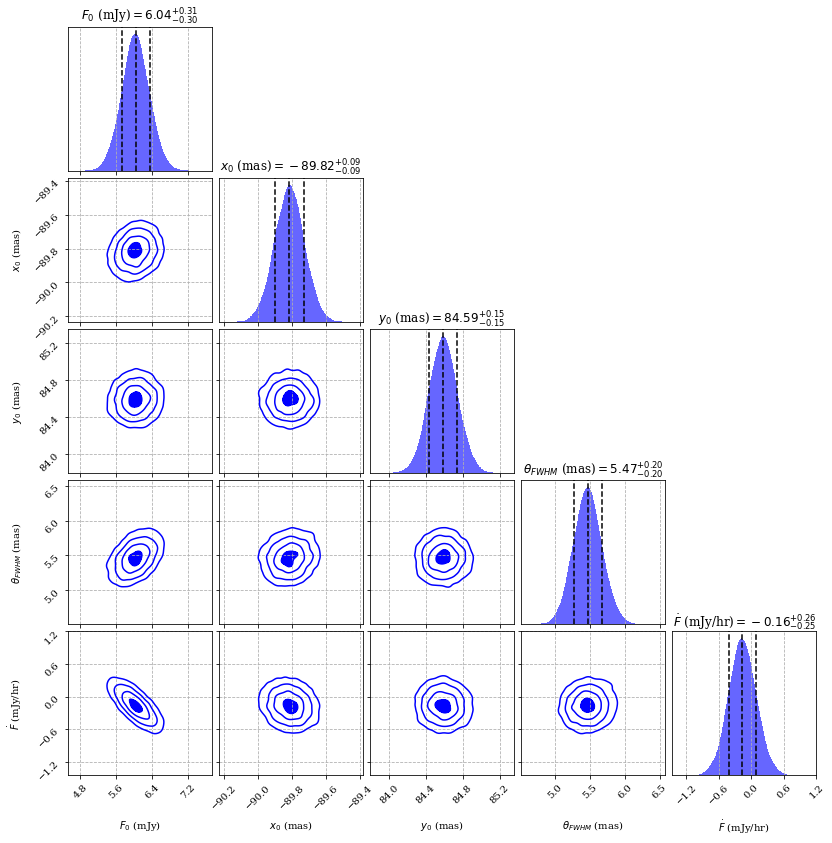

In [50]:
label_names = [r'$F_0$ (mJy)',r'$x_0$ (mas)', r'$y_0$ (mas)', r'$\theta_{FWHM}$ (mas)',r'$\dot{F}$ (mJy/hr)']

# plot results 
fig, ax = dyplot.cornerplot(results_natural, labels = label_names,color='blue', show_titles=False, title_quantiles=None,quantiles=None)

for ii in range(len(label_names)):
    for jj in range(len(label_names)):
        ax[ii,jj].grid(linestyle='--')
        
for ii in range(5):
    median = np.quantile(samples_natural[:,ii],0.5)
    min = np.quantile(samples_natural[:,ii],0.5)-np.quantile(samples_natural[:,ii],0.16)
    max = np.quantile(samples_natural[:,ii],0.84)-np.quantile(samples_natural[:,ii],0.5)
    ax[ii,ii].set_title(label_names[ii]+f'$={median:.2f}_{{-{min:.2f}}}^{{+{max:.2f}}}$')
    ax[ii,ii].axvline(median,ls='--',color='black')
    ax[ii,ii].axvline(median+max,ls='--',color='black')
    ax[ii,ii].axvline(median-min,ls='--',color='black')

fig.savefig(pathname + 'triangle' + outtag + '.pdf',bbox_inches='tight')

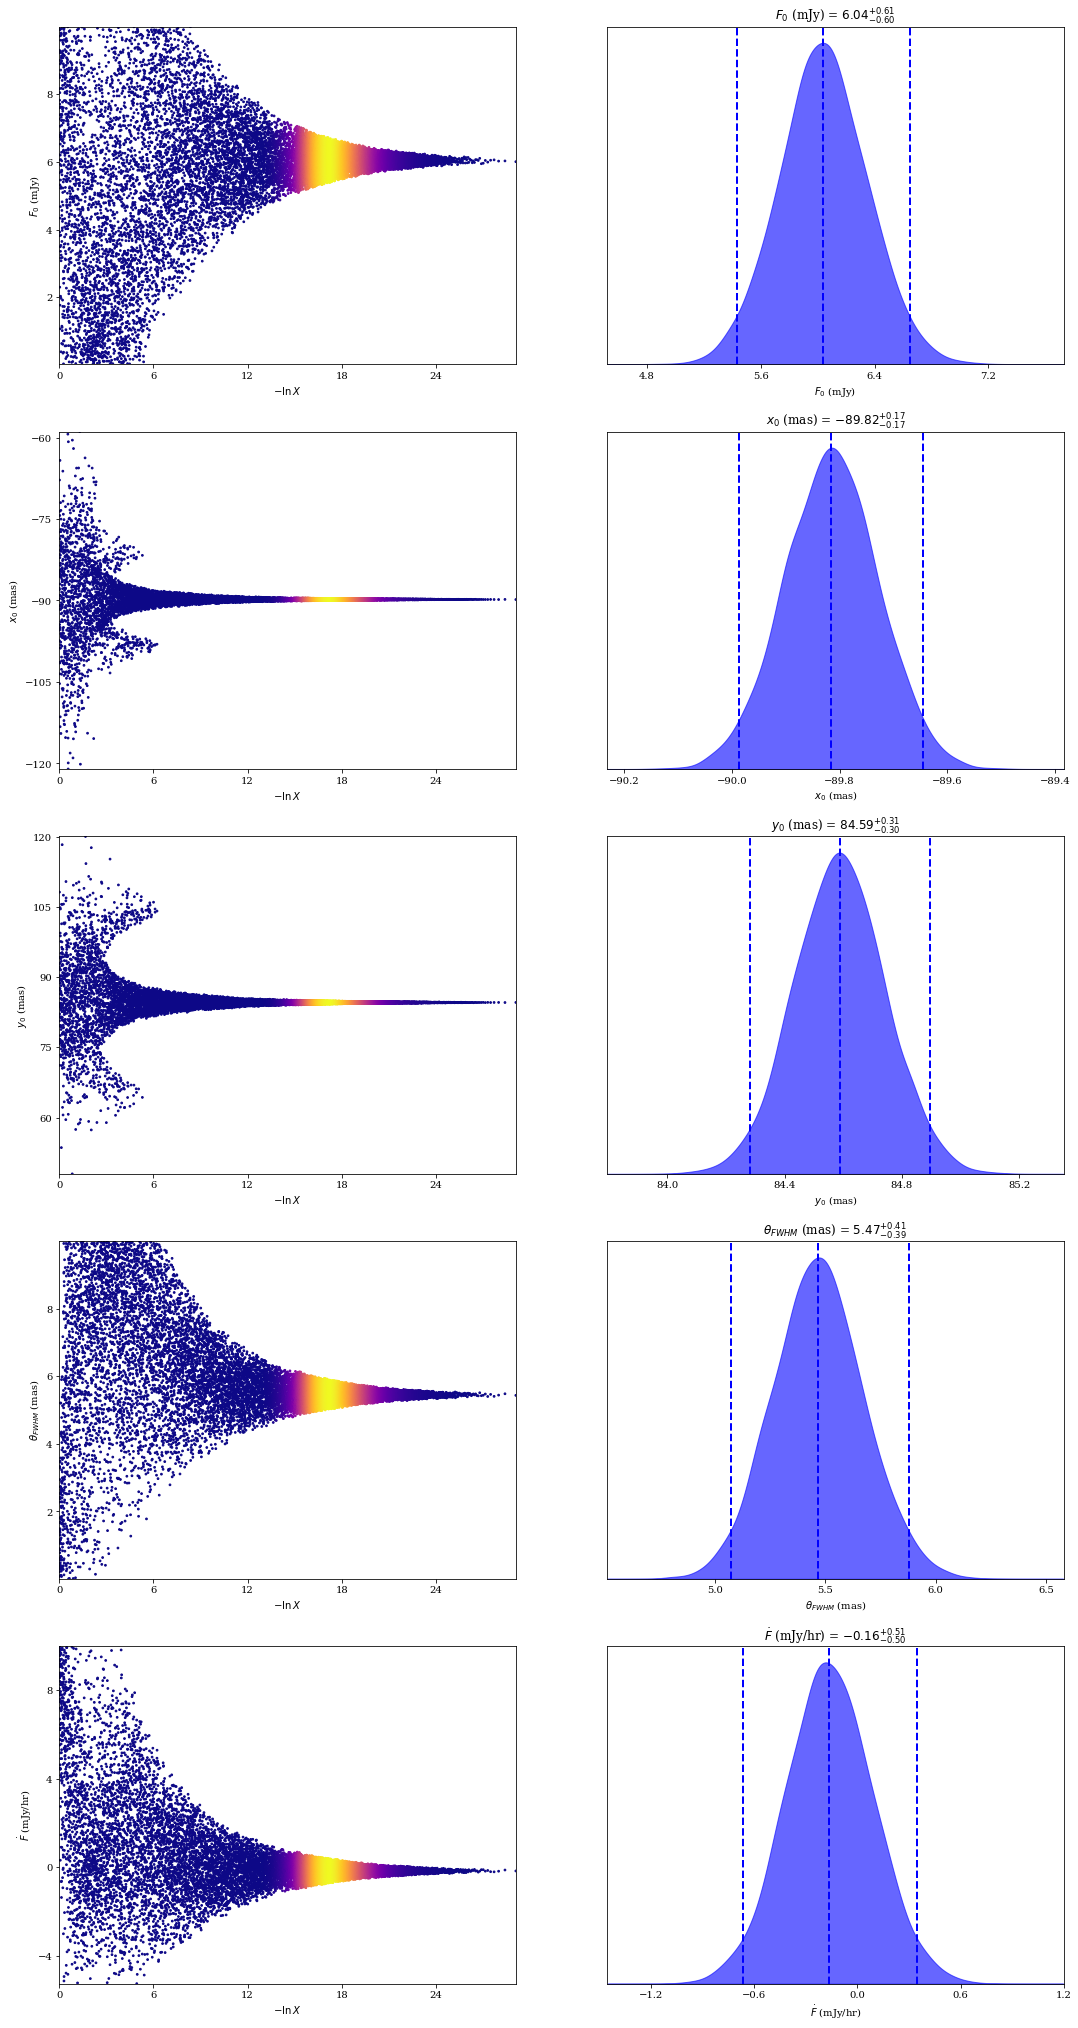

In [51]:
fig, axes=plt.subplots(nrows=5,ncols=2,figsize=(18,36))
dyplot.traceplot(results_natural,fig=(fig,axes),
                             truth_color='black', show_titles=True,
                             trace_cmap='plasma', connect=False,labels = label_names,
                             connect_highlight=range(5))

fig.savefig(pathname + 'trace' + outtag + '.pdf',bbox_inches='tight')

In [52]:
np.save(pathname+outtag+'_results.npy',results)
np.save(pathname+outtag+'_results_natural.npy',results_natural)